# 1D FDTD with First order Hermite Mode:

Grid resolution: 4000 FDTD cells
Simulation steps: 59958 FDTD time steps


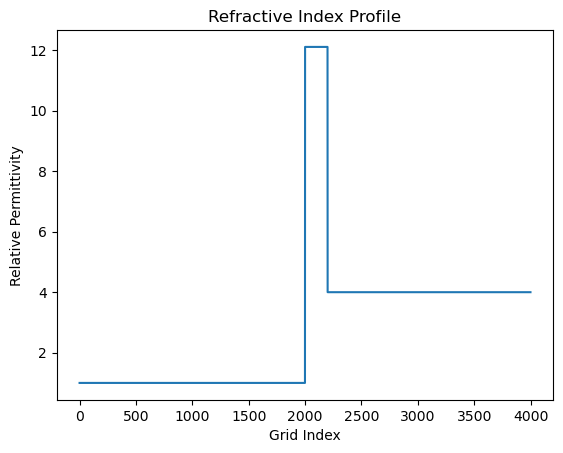

Step 0: E_min = -1.848e-08, E_max = 0.000e+00
Step 1000: E_min = -2.023e-02, E_max = 7.207e-03
Step 2000: E_min = -8.516e-01, E_max = 7.181e-01
Step 3000: E_min = -8.516e-01, E_max = 8.486e-01
Step 4000: E_min = -8.873e-01, E_max = 1.259e+00
Step 5000: E_min = -4.827e-01, E_max = 4.770e-01
Step 6000: E_min = -4.827e-01, E_max = 5.054e-01
Step 7000: E_min = -4.827e-01, E_max = 5.054e-01
Step 8000: E_min = -4.826e-01, E_max = 5.054e-01
Step 9000: E_min = -4.643e-01, E_max = 5.054e-01
Step 10000: E_min = -6.850e-02, E_max = 7.544e-02
Step 11000: E_min = -3.463e-02, E_max = 2.181e-02
Step 12000: E_min = -9.927e-03, E_max = 7.536e-03
Step 13000: E_min = -1.531e-03, E_max = 1.690e-03
Step 14000: E_min = -2.539e-04, E_max = 2.524e-04
Step 15000: E_min = -1.141e-04, E_max = 1.672e-04
Step 16000: E_min = -3.446e-05, E_max = 3.671e-05
Step 17000: E_min = -2.020e-05, E_max = 2.044e-05
Step 18000: E_min = -1.154e-05, E_max = 1.487e-05
Step 19000: E_min = -5.767e-06, E_max = 6.082e-06
Step 20000: E

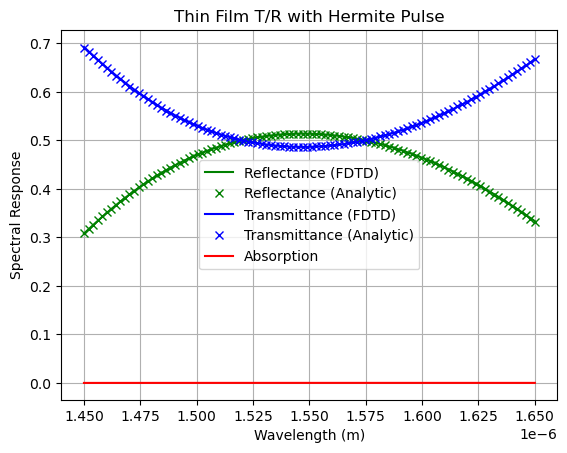

'\n# Save video\nfrom matplotlib.animation import FFMpegWriter\nwriter = FFMpegWriter(fps=30, metadata=dict(artist=\'FDTD Simulation\'), bitrate=1800)\nanimation_obj.save("hermite_fdtd_output.mp4", writer=writer)\n\nplt.show()\n'

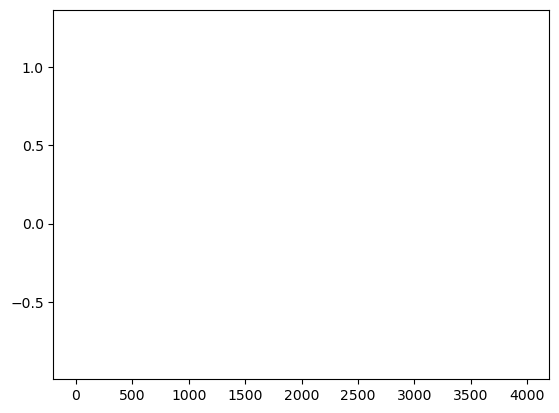

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.special import hermite

# Hermite-Gaussian pulse generator
def hermite_pulse(t_array, width, delay, omega_c=0, amp=1.0, order=1):
    t_normalized = (t_array - delay) / width
    Hn = hermite(order)(t_normalized)
    envelope = np.exp(-t_normalized**2)
    return amp * Hn * envelope * np.sin(omega_c * t_array)

# Physical constants
epsilon_0 = 8.8541878128e-12
mu_0 = 1.256637062e-6
c_light = 2.99792458e8
Z_0 = np.sqrt(mu_0 / epsilon_0)

# Grid setup
domain_length = 20e-6
dx = 5e-9
num_cells = int(domain_length / dx)
print(f"Grid resolution: {num_cells} FDTD cells")

dt = dx / c_light
total_time = 1e-12
num_steps = int(total_time / dt)
print(f"Simulation steps: {num_steps} FDTD time steps")

# Field arrays and materials
electric_field = np.zeros(num_cells)
magnetic_field = np.zeros(num_cells)
relative_eps = np.ones(num_cells)

film_thickness = 1e-6
film_start = num_cells // 2
film_end = int(film_thickness / dx + film_start - 1)
relative_eps[film_start:film_end + 1] = 12.11
relative_eps[film_end + 1:] = 4.0

index_of_refraction = np.sqrt(relative_eps)

plt.plot(relative_eps)
plt.title("Refractive Index Profile")
plt.xlabel("Grid Index")
plt.ylabel("Relative Permittivity")
plt.show()

# FDTD coefficients
magnetic_update_coeff = dt / (mu_0 * dx)
electric_update_coeff = dt / (epsilon_0 * relative_eps * dx)

n_left = index_of_refraction[0]
n_right = index_of_refraction[-1]
a_left = (c_light * dt - dx) / (c_light * dt + dx)
a_right = (c_light / n_right * dt - dx) / (c_light / n_right * dt + dx)

# Source pulse parameters
central_wavelength = 1550e-9
omega_central = 2 * np.pi * c_light / central_wavelength
pulse_duration = 10e-15
pulse_delay = 4 * pulse_duration
hermite_order = 1

source_pos = 10
delay_offset = index_of_refraction[source_pos] * dx / (2 * c_light)
source_impedance = Z_0 / index_of_refraction[source_pos]

# Data arrays
field_snapshots = []
transmission_probe = num_cells - 5
reflection_probe = source_pos - 5
reflected_field = np.zeros(num_steps)
transmitted_field = np.zeros(num_steps)

# Time stepping loop
for step in range(num_steps):
    magnetic_prev = magnetic_field.copy()
    electric_prev = electric_field.copy()

    # Update magnetic field
    magnetic_field[:num_cells-1] += magnetic_update_coeff * (electric_field[1:] - electric_field[:-1])
    magnetic_field[source_pos - 1] -= hermite_pulse((step + 0.5) * dt - delay_offset, pulse_duration, pulse_delay, omega_central, order=hermite_order) / source_impedance

    # Update electric field
    electric_field[1:num_cells - 1] += electric_update_coeff[1:num_cells - 1] * (magnetic_field[1:num_cells - 1] - magnetic_field[0:num_cells - 2])
    electric_field[source_pos] += hermite_pulse((step + 1) * dt, pulse_duration, pulse_delay, omega_central, order=hermite_order)

    # Boundary conditions
    electric_field[0] = electric_prev[1] + a_left * (electric_field[1] - electric_prev[0])
    electric_field[-1] = electric_prev[-2] + a_right * (electric_field[-2] - electric_prev[-1])

    transmitted_field[step] = electric_field[transmission_probe]
    reflected_field[step] = electric_field[reflection_probe]

    if step % 10 == 0:
        print(f"Step {step}: E_min = {np.min(electric_field):.3e}, E_max = {np.max(electric_field):.3e}")
        field_snapshots.append(electric_field.copy())

# DFT calculation
def dft_signal(time_signal, time_array, omega_array):
    spectrum = np.zeros(len(omega_array), dtype='complex128')
    for i, omega in enumerate(omega_array):
        spectrum[i] = np.sum(time_signal * np.exp(1j * omega * time_array))
    return spectrum

# Analytical model
def analytic_thin_film_T_R(n1, n2, n3, wavelengths, thickness):
    r12 = (n1 - n2) / (n1 + n2)
    r23 = (n2 - n3) / (n2 + n3)
    t12 = 2 * n1 / (n1 + n2)
    t23 = 2 * n2 / (n2 + n3)
    beta = 2 * np.pi * n2 * thickness / wavelengths
    r = (r12 + r23 * np.exp(-2j * beta)) / (1 + r12 * r23 * np.exp(-2j * beta))
    t = (t12 * t23 * np.exp(-1j * beta)) / (1 + r12 * r23 * np.exp(-2j * beta))
    return (n3 / n1) * np.abs(t)**2, np.abs(r)**2

# Frequency domain analysis
lambda_range = np.linspace(central_wavelength - 100e-9, central_wavelength + 100e-9, 100)
omega_range = 2 * np.pi * c_light / lambda_range
time_array = np.arange(num_steps) * dt

input_pulse = hermite_pulse(time_array, pulse_duration, pulse_delay, omega_central, order=hermite_order)
transmitted_spectrum = dft_signal(transmitted_field, time_array, omega_range)
reflected_spectrum = dft_signal(reflected_field, time_array, omega_range)
input_spectrum = dft_signal(input_pulse, time_array, omega_range)

Reflectance = np.abs(reflected_spectrum)**2 / np.abs(input_spectrum)**2
Transmittance = np.abs(transmitted_spectrum)**2 / np.abs(input_spectrum)**2 * index_of_refraction[transmission_probe] / index_of_refraction[source_pos]

T_analytic, R_analytic = analytic_thin_film_T_R(1.0, np.sqrt(12.11), np.sqrt(4), lambda_range, film_thickness)

# Plot results
plt.plot(lambda_range, Reflectance, 'g', label="Reflectance (FDTD)")
plt.plot(lambda_range, R_analytic, 'gx', label="Reflectance (Analytic)")
plt.plot(lambda_range, Transmittance, 'b', label="Transmittance (FDTD)")
plt.plot(lambda_range, T_analytic, 'bx', label="Transmittance (Analytic)")
plt.plot(lambda_range, 1 - Reflectance - Transmittance, 'red', label="Absorption")
plt.xlabel("Wavelength (m)")
plt.ylabel("Spectral Response")
plt.title("Thin Film T/R with Hermite Pulse")
plt.legend()
plt.grid(True)
plt.show()

# Animate propagation
frames = []
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for frame_data in field_snapshots:
    line_plot, = ax.plot(frame_data, color='blue')
    frames.append([line_plot])

animation_obj = animation.ArtistAnimation(fig, frames, interval=20, blit=True, repeat_delay=1000)

# Save video
"""
from matplotlib.animation import FFMpegWriter
writer = FFMpegWriter(fps=30, metadata=dict(artist='FDTD Simulation'), bitrate=1800)
animation_obj.save("hermite_fdtd_output.mp4", writer=writer)

plt.show()
"""

# 1D FDTD with Second order Hermite Mode:

Grid resolution: 4000 FDTD cells
Simulation steps: 59958 FDTD time steps


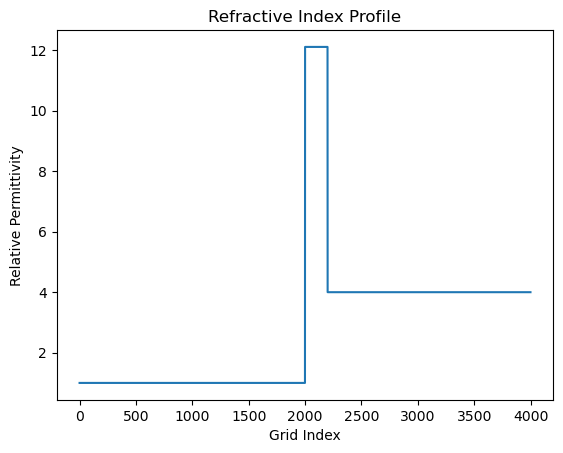

Step 0: E_min = 0.000e+00, E_max = 1.432e-07
Step 1000: E_min = -3.392e-02, E_max = 8.560e-02
Step 2000: E_min = -7.795e-01, E_max = 8.834e-01
Step 3000: E_min = -1.654e+00, E_max = 2.000e+00
Step 4000: E_min = -1.234e+00, E_max = 1.520e+00
Step 5000: E_min = -1.298e+00, E_max = 1.275e+00
Step 6000: E_min = -1.090e+00, E_max = 1.141e+00
Step 7000: E_min = -9.394e-01, E_max = 1.141e+00
Step 8000: E_min = -9.392e-01, E_max = 1.141e+00
Step 9000: E_min = -3.763e-01, E_max = 4.330e-01
Step 10000: E_min = -1.583e-01, E_max = 2.205e-01
Step 11000: E_min = -5.555e-02, E_max = 4.481e-02
Step 12000: E_min = -8.370e-03, E_max = 9.698e-03
Step 13000: E_min = -3.558e-03, E_max = 1.686e-03
Step 14000: E_min = -8.637e-04, E_max = 7.405e-04
Step 15000: E_min = -1.870e-04, E_max = 2.191e-04
Step 16000: E_min = -4.273e-05, E_max = 4.385e-05
Step 17000: E_min = -4.272e-05, E_max = 4.385e-05
Step 18000: E_min = -1.565e-05, E_max = 1.535e-05
Step 19000: E_min = -4.628e-06, E_max = 4.739e-06
Step 20000: E_

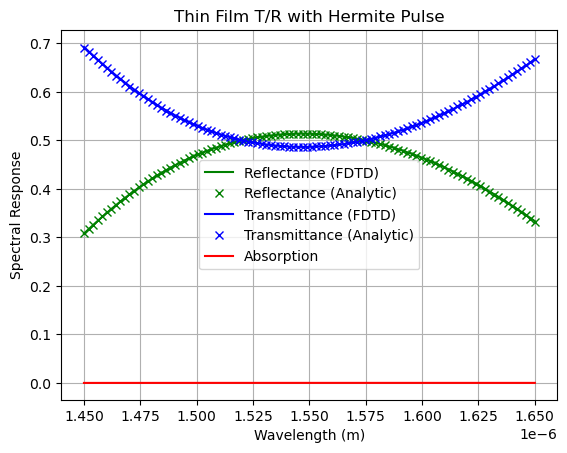

'\n# Save video\nfrom matplotlib.animation import FFMpegWriter\nwriter = FFMpegWriter(fps=30, metadata=dict(artist=\'FDTD Simulation\'), bitrate=1800)\nanimation_obj.save("hermite_fdtd_output.mp4", writer=writer)\n\nplt.show()\n'

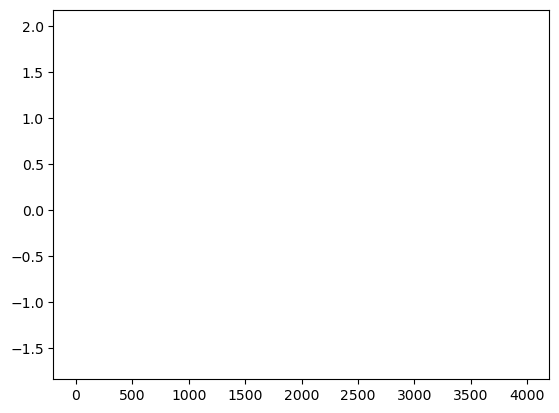

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.special import hermite

# Hermite-Gaussian pulse generator
def hermite_pulse(t_array, width, delay, omega_c=0, amp=1.0, order=1):
    t_normalized = (t_array - delay) / width
    Hn = hermite(order)(t_normalized)
    envelope = np.exp(-t_normalized**2)
    return amp * Hn * envelope * np.sin(omega_c * t_array)

# Physical constants
epsilon_0 = 8.8541878128e-12
mu_0 = 1.256637062e-6
c_light = 2.99792458e8
Z_0 = np.sqrt(mu_0 / epsilon_0)

# Grid setup
domain_length = 20e-6
dx = 5e-9
num_cells = int(domain_length / dx)
print(f"Grid resolution: {num_cells} FDTD cells")

dt = dx / c_light
total_time = 1e-12
num_steps = int(total_time / dt)
print(f"Simulation steps: {num_steps} FDTD time steps")

# Field arrays and materials
electric_field = np.zeros(num_cells)
magnetic_field = np.zeros(num_cells)
relative_eps = np.ones(num_cells)

film_thickness = 1e-6
film_start = num_cells // 2
film_end = int(film_thickness / dx + film_start - 1)
relative_eps[film_start:film_end + 1] = 12.11
relative_eps[film_end + 1:] = 4.0

index_of_refraction = np.sqrt(relative_eps)

plt.plot(relative_eps)
plt.title("Refractive Index Profile")
plt.xlabel("Grid Index")
plt.ylabel("Relative Permittivity")
plt.show()

# FDTD coefficients
magnetic_update_coeff = dt / (mu_0 * dx)
electric_update_coeff = dt / (epsilon_0 * relative_eps * dx)

n_left = index_of_refraction[0]
n_right = index_of_refraction[-1]
a_left = (c_light * dt - dx) / (c_light * dt + dx)
a_right = (c_light / n_right * dt - dx) / (c_light / n_right * dt + dx)

# Source pulse parameters
central_wavelength = 1550e-9
omega_central = 2 * np.pi * c_light / central_wavelength
pulse_duration = 10e-15
pulse_delay = 4 * pulse_duration
hermite_order = 2

source_pos = 10
delay_offset = index_of_refraction[source_pos] * dx / (2 * c_light)
source_impedance = Z_0 / index_of_refraction[source_pos]

# Data arrays
field_snapshots = []
transmission_probe = num_cells - 5
reflection_probe = source_pos - 5
reflected_field = np.zeros(num_steps)
transmitted_field = np.zeros(num_steps)

# Time stepping loop
for step in range(num_steps):
    magnetic_prev = magnetic_field.copy()
    electric_prev = electric_field.copy()

    # Update magnetic field
    magnetic_field[:num_cells-1] += magnetic_update_coeff * (electric_field[1:] - electric_field[:-1])
    magnetic_field[source_pos - 1] -= hermite_pulse((step + 0.5) * dt - delay_offset, pulse_duration, pulse_delay, omega_central, order=hermite_order) / source_impedance

    # Update electric field
    electric_field[1:num_cells - 1] += electric_update_coeff[1:num_cells - 1] * (magnetic_field[1:num_cells - 1] - magnetic_field[0:num_cells - 2])
    electric_field[source_pos] += hermite_pulse((step + 1) * dt, pulse_duration, pulse_delay, omega_central, order=hermite_order)

    # Boundary conditions
    electric_field[0] = electric_prev[1] + a_left * (electric_field[1] - electric_prev[0])
    electric_field[-1] = electric_prev[-2] + a_right * (electric_field[-2] - electric_prev[-1])

    transmitted_field[step] = electric_field[transmission_probe]
    reflected_field[step] = electric_field[reflection_probe]

    if step % 10 == 0:
        print(f"Step {step}: E_min = {np.min(electric_field):.3e}, E_max = {np.max(electric_field):.3e}")
        field_snapshots.append(electric_field.copy())

# DFT calculation
def dft_signal(time_signal, time_array, omega_array):
    spectrum = np.zeros(len(omega_array), dtype='complex128')
    for i, omega in enumerate(omega_array):
        spectrum[i] = np.sum(time_signal * np.exp(1j * omega * time_array))
    return spectrum

# Analytical model
def analytic_thin_film_T_R(n1, n2, n3, wavelengths, thickness):
    r12 = (n1 - n2) / (n1 + n2)
    r23 = (n2 - n3) / (n2 + n3)
    t12 = 2 * n1 / (n1 + n2)
    t23 = 2 * n2 / (n2 + n3)
    beta = 2 * np.pi * n2 * thickness / wavelengths
    r = (r12 + r23 * np.exp(-2j * beta)) / (1 + r12 * r23 * np.exp(-2j * beta))
    t = (t12 * t23 * np.exp(-1j * beta)) / (1 + r12 * r23 * np.exp(-2j * beta))
    return (n3 / n1) * np.abs(t)**2, np.abs(r)**2

# Frequency domain analysis
lambda_range = np.linspace(central_wavelength - 100e-9, central_wavelength + 100e-9, 100)
omega_range = 2 * np.pi * c_light / lambda_range
time_array = np.arange(num_steps) * dt

input_pulse = hermite_pulse(time_array, pulse_duration, pulse_delay, omega_central, order=hermite_order)
transmitted_spectrum = dft_signal(transmitted_field, time_array, omega_range)
reflected_spectrum = dft_signal(reflected_field, time_array, omega_range)
input_spectrum = dft_signal(input_pulse, time_array, omega_range)

Reflectance = np.abs(reflected_spectrum)**2 / np.abs(input_spectrum)**2
Transmittance = np.abs(transmitted_spectrum)**2 / np.abs(input_spectrum)**2 * index_of_refraction[transmission_probe] / index_of_refraction[source_pos]

T_analytic, R_analytic = analytic_thin_film_T_R(1.0, np.sqrt(12.11), np.sqrt(4), lambda_range, film_thickness)

# Plot results
plt.plot(lambda_range, Reflectance, 'g', label="Reflectance (FDTD)")
plt.plot(lambda_range, R_analytic, 'gx', label="Reflectance (Analytic)")
plt.plot(lambda_range, Transmittance, 'b', label="Transmittance (FDTD)")
plt.plot(lambda_range, T_analytic, 'bx', label="Transmittance (Analytic)")
plt.plot(lambda_range, 1 - Reflectance - Transmittance, 'red', label="Absorption")
plt.xlabel("Wavelength (m)")
plt.ylabel("Spectral Response")
plt.title("Thin Film T/R with Hermite Pulse")
plt.legend()
plt.grid(True)
plt.show()

# Animate propagation
frames = []
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for frame_data in field_snapshots:
    line_plot, = ax.plot(frame_data, color='blue')
    frames.append([line_plot])

animation_obj = animation.ArtistAnimation(fig, frames, interval=20, blit=True, repeat_delay=1000)

# Save video
"""
from matplotlib.animation import FFMpegWriter
writer = FFMpegWriter(fps=30, metadata=dict(artist='FDTD Simulation'), bitrate=1800)
animation_obj.save("hermite_fdtd_output.mp4", writer=writer)

plt.show()
"""